In [1]:
import time
from src import LogConfig as log
from src import DataPre as dp
from src import DetialLog as dl
from src import LoadConfig as lc
from src import RotateTrain as rt
from src import models
import numpy as np
from tqdm import tqdm
import os
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F




In [2]:
etdata = pd.read_csv('../ETDataset/ETT-small/ETTm2.csv')
etdata.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001


In [3]:
etdata.shape

(69680, 8)

Text(0, 0.5, 'Oil')

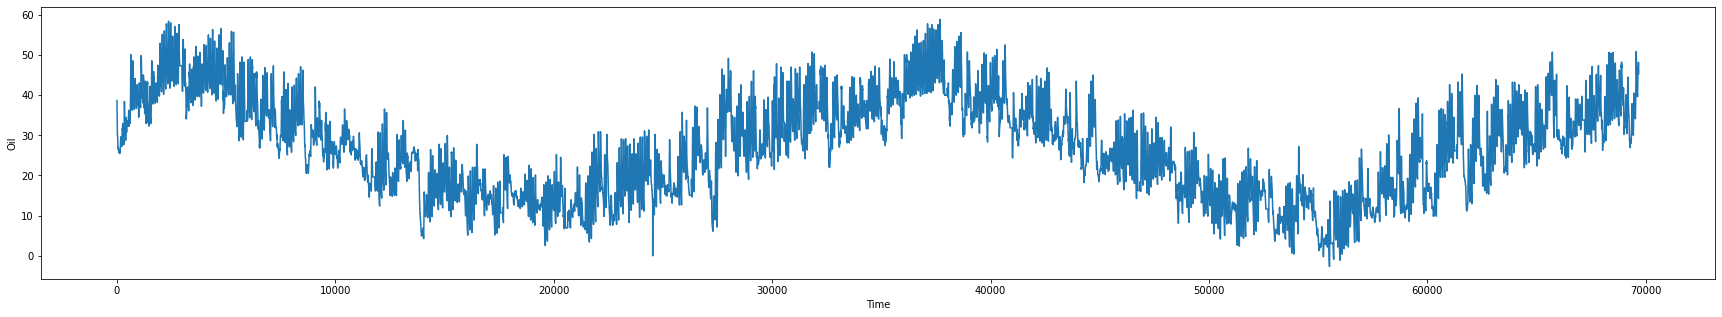

In [4]:
plt.figure(figsize=(30,5))
plt.plot(etdata['OT'])
plt.xlabel('Time')
plt.ylabel('Oil')

In [5]:
ot = etdata['OT'].values

In [6]:
scaleddata = (ot-ot.min())/(ot.max()-ot.min())

Text(0, 0.5, 'Oil')

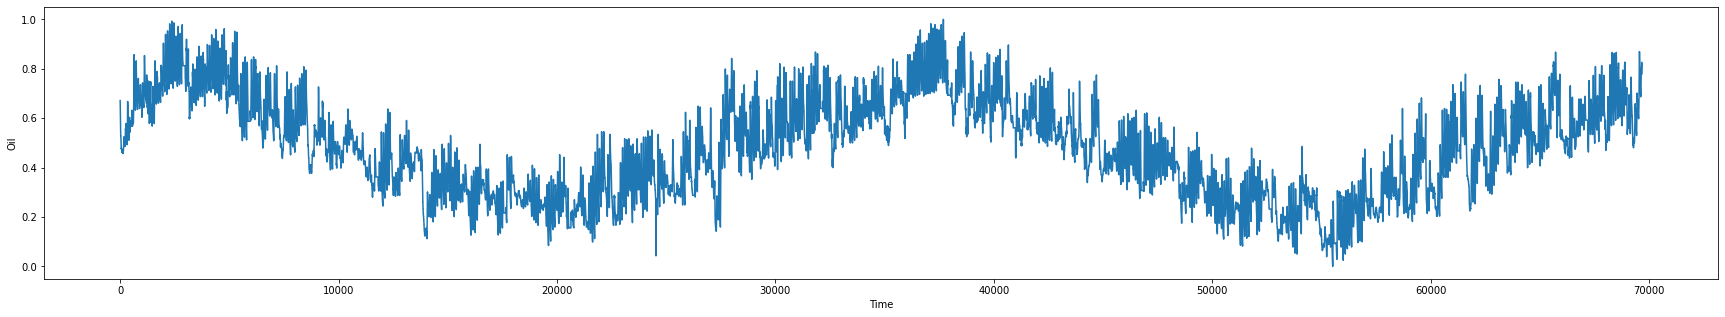

In [7]:
plt.figure(figsize=(30,5))
plt.plot(scaleddata)
plt.xlabel('Time')
plt.ylabel('Oil')

In [8]:
datapre = dp.Datapre(data=scaleddata,
                     window_len=96)

In [9]:
slicesX, SlicesT = datapre.series2slices(etdata['OT'])
originalDFTtri = datapre.slices2DFTtri(slicesX)

In [10]:
originalDFTtri.shape

(69584, 96, 96)

In [11]:
DFTtriDescartes = np.stack([originalDFTtri.real, originalDFTtri.imag], axis=-3)
originalDFTtri = 0

In [12]:
DFTtriDescartes.shape

(69584, 2, 96, 96)

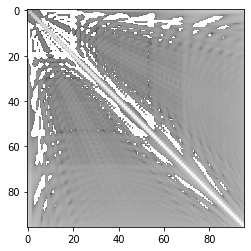

In [13]:
plt.imshow(DFTtriDescartes[10][0],norm=colors.LogNorm(),cmap='gray')

In [14]:
DFTtriDescartes[0][0][0]

array([ 2.5917999e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        7.1054274e-15,  0.0000000e+00, -7.1054274e-15,  0.0000000e+00,
        0.0000000e+00, -2.1949959e-01, -4.0415439e-01, -5.1934159e-01,
       -1.2600347e-01,  2.8040975e-01,  6.3176590e-01,  9.0071350e-01,
        1.0834566e+00,  1.1878225e+00,  1.2261817e+00,  1.2116753e+00,
        1.1564229e+00,  1.2908272e+00,  1.6152854e+00,  1.8966433e+00,
        2.1213043e+00,  2.2829051e+00,  2.3802934e+00,  2.4158244e+00,
        2.3940334e+00,  2.3206596e+00,  2.2019567e+00,  2.2637322e+00,
        2.2885787e+00,  2.2754788e+00,  2.2247467e+00,  2.1377027e+00,
        2.0163877e+00,  1.8633218e+00,  1.6813136e+00,  1.4733095e+00,
        1.2422791e+00,  9.9113250e-01,  7.2266161e-01,  2.1949959e-01,
       -2.9375839e-01, -5.9106779e-01, -4.4979486e-01, -3.1245264e-01,
       -1.8511713e-01, -7.2726570e-02,  2.4031812e-01,  5.2994400e-01,
        7.9111236e-01,  1.0199746e+00,  1.2137260e+00,  1.3704656e+00,
      

In [15]:
prefix_path = './config/rotate_prefix.json'
configs_path = './config/rotate_configs.json'
loadconfig = lc.LoadConfig(prefix_path=prefix_path,
                        configs_path=configs_path)
config = loadconfig.configs[0]
mean_accu = 0
file_name = time.strftime("%m%d-%H%M%S", time.localtime())
exp_config = loadconfig.prefix
exp_config.update(config)

total_size = DFTtriDescartes.shape[0] - exp_config['window_len']-exp_config['O_size']
detail = dl.DetailLog(test_size=total_size,
                      O_size=exp_config['O_size'],
                      file_name=file_name)
seed = int(time.time())
train_winlen = exp_config['window_len']
O_size = exp_config['O_size']

In [16]:
if exp_config['model'] == 'ALEXNET':
    model = models.DFTALEX(seq_length=exp_config['window_len'],
                                    in_channels=exp_config['in_channels'],
                                    out_channels=exp_config['out_channels'],
                                    kernel_size=exp_config['kernel_size'],
                                    p=exp_config['dropout_rate'])

In [17]:
train_start = 0
test_start = train_start+train_winlen+1
rotate_data_x = DFTtriDescartes[train_start:train_start:train_winlen]
rotate_data_y = SlicesT[train_start:train_start:O_size]
train_final = int(total_size*0.7)
vali_final = int(total_size*0.2)

In [62]:
class DFTDataset(Dataset):
    def __init__(self, 
                 data, 
                 window_size=96,
                 O_size=96,
                 flip=True,
                 norm=True):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data = data
        self.window_size = window_size
        self.O_size = O_size
        self.flip = flip
        self.dataset_len = len(data) - window_size - O_size + 1
        self.slicesX_ = np.zeros((self.dataset_len, window_size))
        self.slicesT_ = np.zeros((self.dataset_len, O_size))

        # 构建输入和目标序列
        for i in range(self.dataset_len):
            self.slicesX_[i] = self.data[i:i + window_size]
            self.slicesT_[i] = self.data[i + window_size:i + window_size + O_size]
        if norm:
            self.minmaxnorm()
        else:
            self.slicesX = self.slicesX_
            self.slicesT = self.slicesT_
        self.input_DFTtri = self.slices2DFTtri(self.slicesX)
        self.slicesT = self.slicesT
        #self.input_DFTtri = ei.rearrange(self.slices2DFTtri(self.slicesX),'b h w c -> b c h w')
        

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        input_DFTtri = self.input_DFTtri[idx]
        target_seq = self.slicesT[idx]
        
        return input_DFTtri, target_seq
    def slices2DFTtri(self, 
                      slicesX, 
                      without_f0=False):
        timeSteps = slicesX.shape[0]
        windowSize = slicesX.shape[1]
        max_freq = int((windowSize + 3) / 2)  # int()函数只保留整数部分
        # complex128就是64+64的复数
        # timestep是矩阵的数量，后面两个参数决定了每个矩阵的维度，生成1247个12*12的matrix
        DFTtri = np.zeros([timeSteps, windowSize, windowSize], dtype = np.complex64) #降低精度防止爆内存
        for i in tqdm(range(timeSteps)):
            for j in range(windowSize):
                fft = np.fft.fft(slicesX[i, -(1+j):])
                DFTtri[i, :(j+1), j] = fft[::-1]
                if self.flip:
                    DFTtri[i, j, :(j+1)] = fft[::-1] # Flip padding
        if without_f0:
            DFTtri = DFTtri[:,1:,1:]
        DFTtriDescartes = np.stack([DFTtri.real, DFTtri.imag], axis=-3)
        return DFTtriDescartes
    def minmaxnorm(self):
        self.slicesX = (self.slicesX_ - self.slicesX_.min()) / (self.slicesX_.max() - self.slicesX_.min())
        self.slicesT = (self.slicesT_ - self.slicesT_.min()) / (self.slicesT_.max() - self.slicesT_.min())
        
    def inverse_minmaxnorm(self, data):
        return (data * (self.slicesX_.max() - self.slicesX_.min())) + self.slicesX_.min()


# 创建时间序列数据（示例数据）


# 创建自定义数据集实例
dft_dataset = DFTDataset(ot)

# 划分数据集为训练集、验证集和测试集
dataset_size = len(dft_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
# 创建数据加载器
dataloader = torch.utils.data.DataLoader(dft_dataset, batch_size=32, shuffle=False,num_workers=4)

100%|██████████| 69489/69489 [01:08<00:00, 1016.14it/s]


In [63]:
class MAN(nn.Module):
    def __init__(self, num_classes=96):
        super(MAN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(2, 48, kernel_size=3, stride=1, padding=1),  # 修改输入通道数为2，输出通道数为48，卷积核大小为3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 修改池化核大小为2，步长为2
            nn.Conv2d(48, 128, kernel_size=3, stride=1, padding=1),  # 输出通道数改为128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),  # 输出通道数改为192
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),  # 输出通道数改为192
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),  # 输出通道数改为128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 创建一个示例模型
model = MAN()

# 创建一个示例输入
input_data = torch.randn(10, 2, 96, 96)  # 输入数据格式为(batch_size, channels, height, width)

# 使用模型进行预测
output = model(input_data)
print(output.shape)  # 输出 (10, 96)


torch.Size([10, 96])


In [66]:
model = MAN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss, batch_loss, vali_loss, test_loss = 0,0,0,0
    count=0
    for inputs, targets in tqdm(dataloader, 
                                desc=f'Epoch {epoch + 1}/{num_epochs},Loss={batch_loss}', 
                                leave=False):
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        if count< train_size:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            running_loss += loss.item() * inputs.size(0)
        elif count>= train_size and count< train_size+val_size:
            model.eval()
            outputs = model(inputs)
            invtrans_outputs = dft_dataset.inverse_minmaxnorm(outputs)
            invtrans_targets = dft_dataset.inverse_minmaxnorm(targets)
            loss = criterion(invtrans_outputs, invtrans_targets)
            vali_loss += loss.item() * inputs.size(0)
        elif count>= train_size+val_size:
            model.eval()
            outputs = model(inputs)
            invtrans_outputs = dft_dataset.inverse_minmaxnorm(outputs)
            invtrans_targets = dft_dataset.inverse_minmaxnorm(targets)
            loss = criterion(invtrans_outputs, invtrans_targets)
            test_loss += loss.item() * inputs.size(0)
        count+=inputs.size(0)
    epoch_loss = running_loss / train_size
    vali_loss = vali_loss / val_size
    test_loss = test_loss / (dataset_size-train_size-val_size)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Vali_Loss:{vali_loss}, Test_Loss:{test_loss}")

print("Finished Training")

Epoch 1/10, Loss: 0.0029, Vali_Loss:9.20673862296957, Test_Loss:9.209433690636558


Epoch 2/10, Loss: 0.0029, Vali_Loss:9.490269018303888, Test_Loss:9.359187749077309


Epoch 3/10, Loss: 0.0028, Vali_Loss:9.211096654490074, Test_Loss:9.015790492581399


Epoch 4/10, Loss: 0.0028, Vali_Loss:9.989638830919546, Test_Loss:9.795636782278061


Epoch 5/10, Loss: 0.0027, Vali_Loss:8.570051410792543, Test_Loss:8.40884269766777


Epoch 6/10, Loss: 0.0027, Vali_Loss:8.194275738249994, Test_Loss:8.757776186340823


Epoch 7/10, Loss: 0.0026, Vali_Loss:8.727081616719564, Test_Loss:8.375645721908164


Epoch 8/10, Loss: 0.0026, Vali_Loss:8.215951426110188, Test_Loss:8.255882258037499


Epoch 9/10, Loss: 0.0025, Vali_Loss:9.204345549669634, Test_Loss:9.332563912545153


Epoch 10/10, Loss: 0.0025, Vali_Loss:7.822494479384172, Test_Loss:7.992738568171279
Finished Training


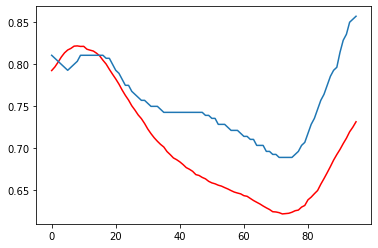

In [61]:
model.

In [46]:
type(loss.item())

float